In [1]:
import scanpy as sc
import os
import random
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/pbmc/data/donor_similarity"

In [3]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/donor_cytokine_displacements.pkl", "rb") as file:
    donor_cytokine_displacements = pickle.load(file)


In [4]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_order.pkl", "rb") as file:
    cyto_order = pickle.load(file)

In [5]:
donor_order = [f"Donor{i}" for i in range(1,13)]

In [6]:
df_donor_sim = pd.DataFrame(index=donor_order, columns=donor_order)
for donor1 in donor_order:
    for donor2 in donor_order:
        repr_d1 = np.concatenate([donor_cytokine_displacements[donor1][cytokine] for cytokine in cyto_order], axis=1)
        repr_d2 = np.concatenate([donor_cytokine_displacements[donor2][cytokine] for cytokine in cyto_order], axis=1)
        df_donor_sim.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]


df_donor_sim = df_donor_sim.astype("float")

<Figure size 200x200 with 0 Axes>

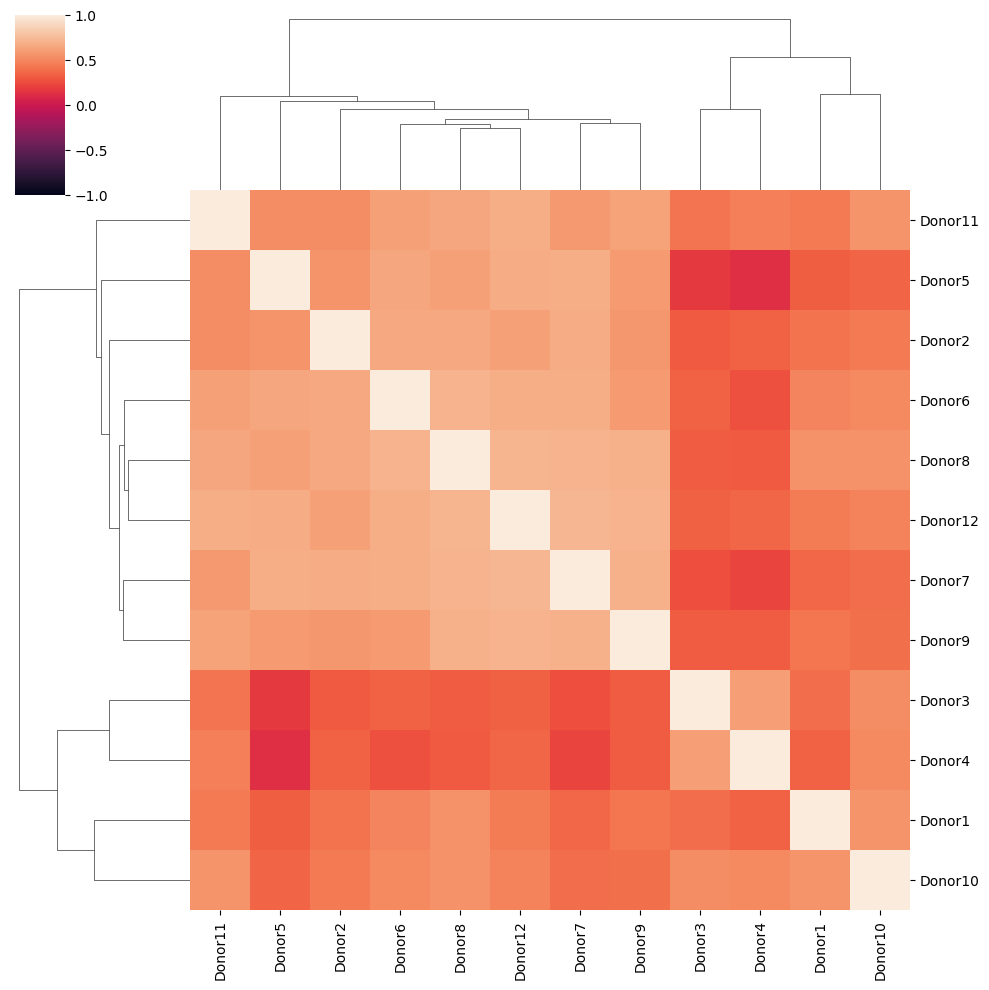

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(2,2))  # Adjust width and height as needed

# Create the heatmap
clustermap = sns.clustermap(
    df_donor_sim,
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)




In [8]:
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
row_order == col_order
donor_order = df_donor_sim.index[row_order]
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/donor_order.pkl", "wb") as file:
    pickle.dump(donor_order, file)

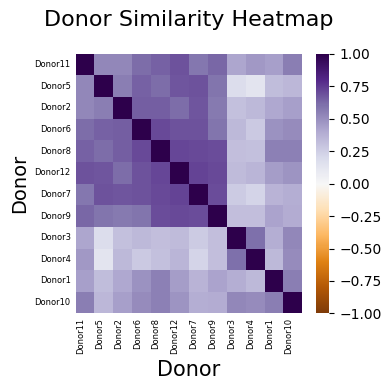

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(4, 4))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_donor_sim.loc[donor_order, donor_order],
    cmap="PuOr",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Donor Similarity Heatmap", fontsize=16, pad=20)
plt.xlabel("Donor", fontsize=15)
plt.ylabel("Donor", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "donor_similarity_heatmap.pdf"), format="pdf", bbox_inches="tight")

plt.tight_layout() 
plt.show()


# Similarity for cytokine families

In [10]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/cyto_to_fam.pkl", "rb") as file:
    cyto_to_family = pickle.load(file)


In [11]:
families = list(set(cyto_to_family.values()))

In [12]:
len(families)

14

In [13]:
donor_fam_sims = {}
for fam in families:
    df_donor_sim = pd.DataFrame(index=donor_order, columns=donor_order)
    for donor1 in donor_order:
        for donor2 in donor_order:
            repr_d1 = np.concatenate([donor_cytokine_displacements[donor1][cytokine] for cytokine in cyto_order if cyto_to_family[cytokine] in fam], axis=1)
            repr_d2 = np.concatenate([donor_cytokine_displacements[donor2][cytokine] for cytokine in cyto_order if cyto_to_family[cytokine] in fam], axis=1)
            df_donor_sim.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]
    
    
    donor_fam_sims[fam] = df_donor_sim.astype("float")

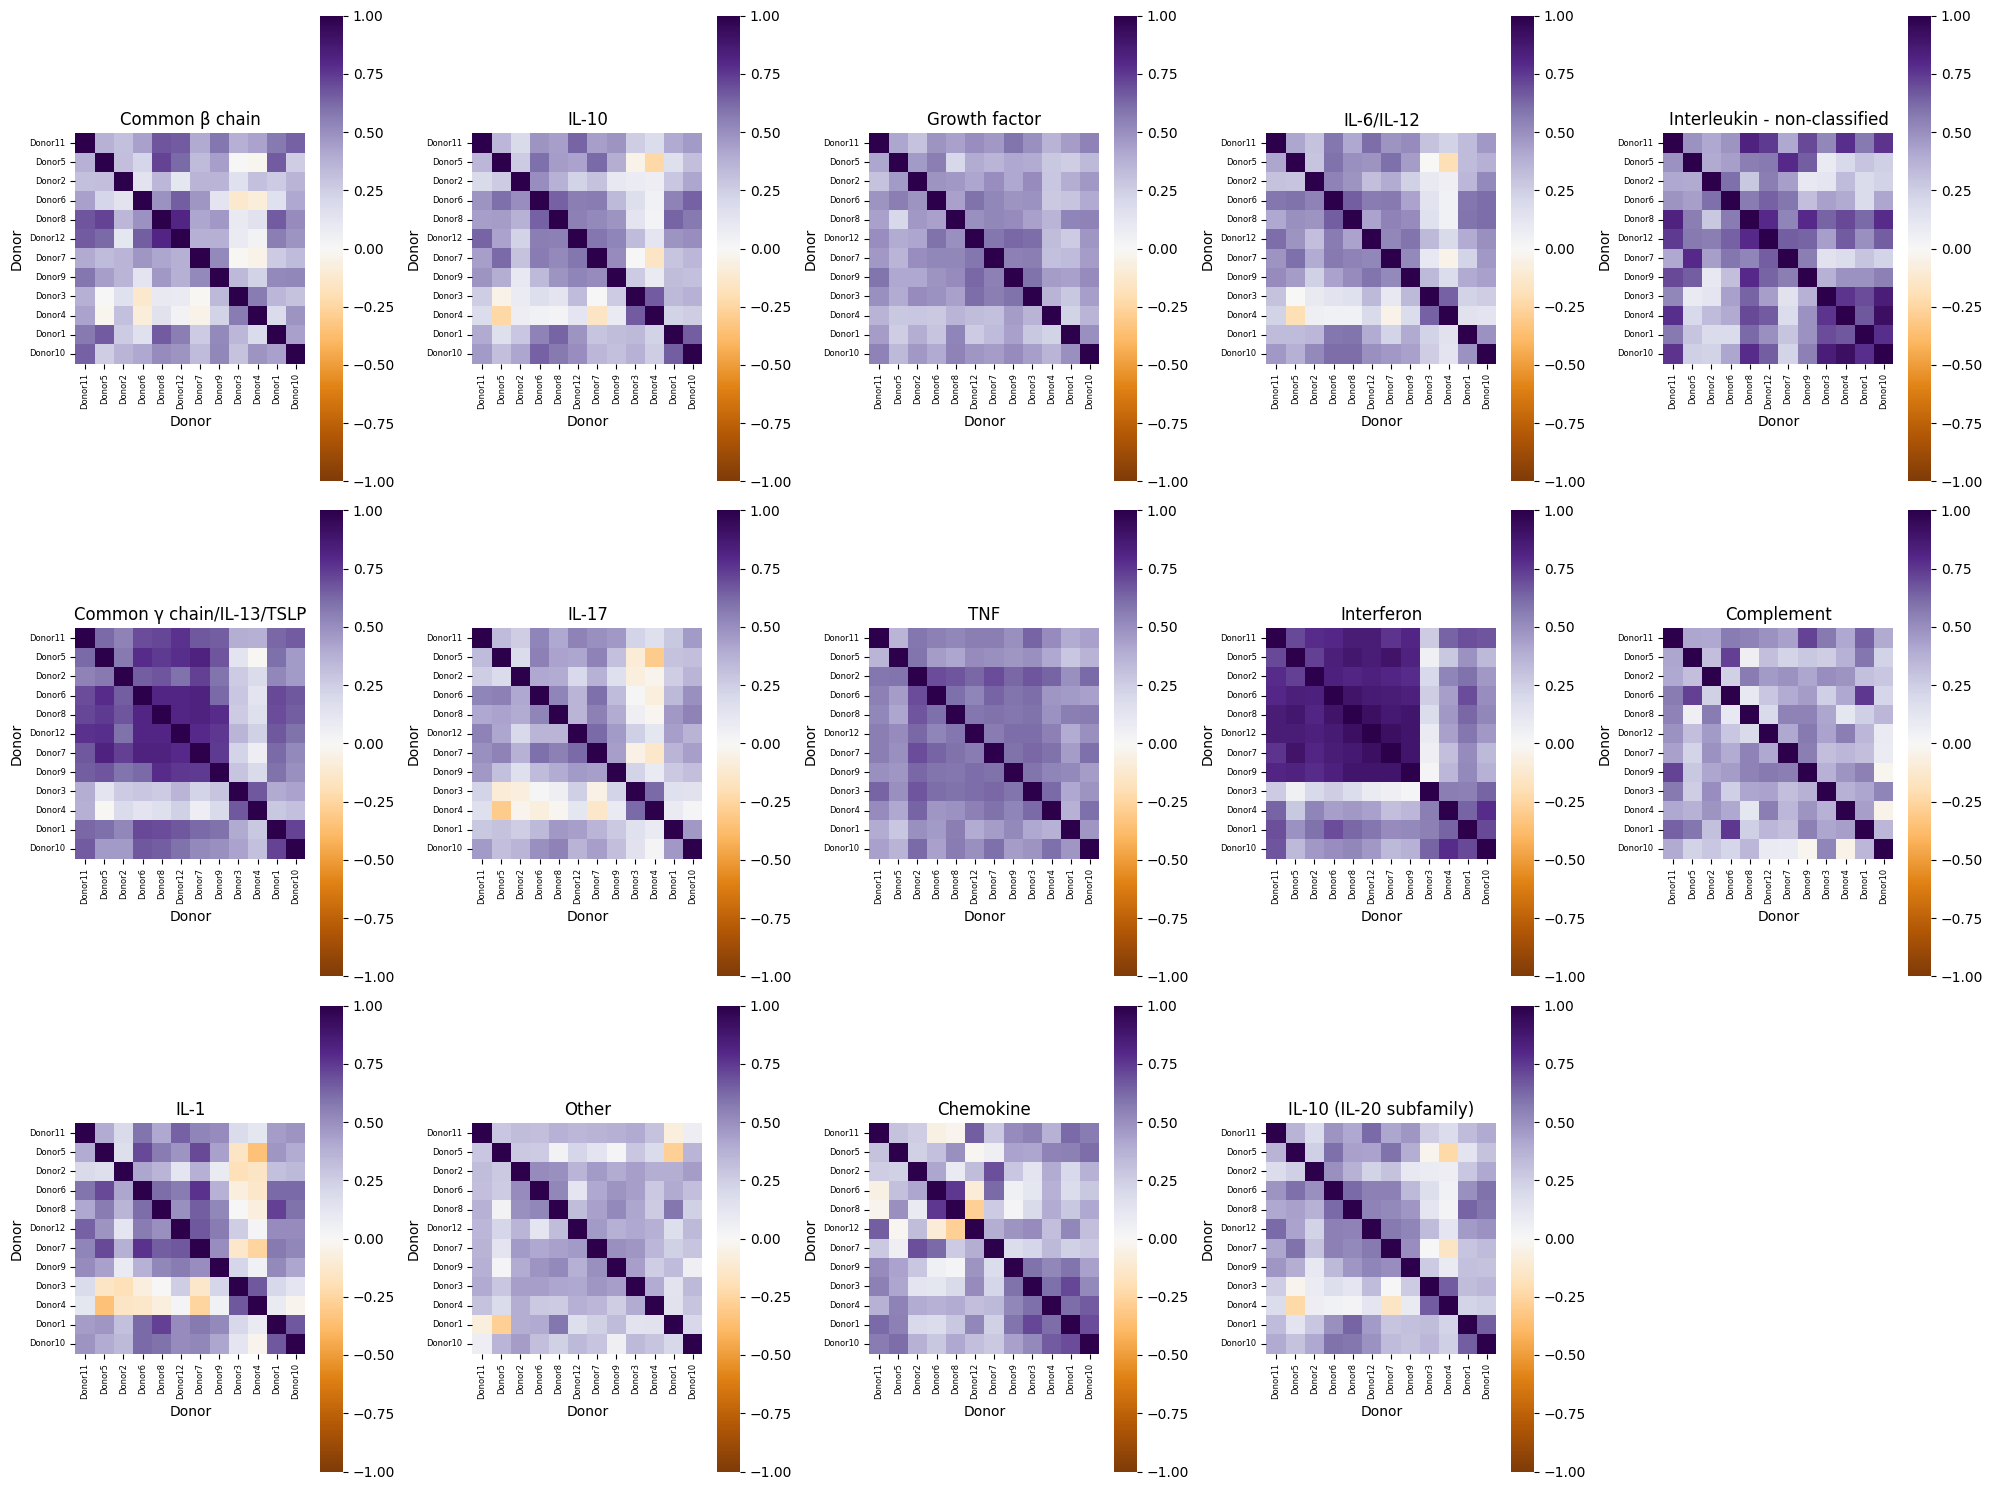

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
heatmap_dict=donor_fam_sims

# Create a figure with subplots (3 rows x 4 columns for 12 plots)
fig, axes = plt.subplots(3, 5, figsize=(20, 15))  # Adjust the size as needed
axes = axes.flatten()  # Flatten to easily iterate over

# Iterate through the dictionary and plot each heatmap
for idx, (key, df) in enumerate(heatmap_dict.items()):
    sns.heatmap(
        df,
        cmap="PuOr",
        vmin=-1,
        vmax=1,
        xticklabels=True,
        yticklabels=True,
        square=True,
        ax=axes[idx]  # Use the current subplot
    )
    axes[idx].set_title(key, fontsize=12)
    axes[idx].set_xlabel("Donor", fontsize=10)
    axes[idx].set_ylabel("Donor", fontsize=10)
    axes[idx].tick_params(axis='x', labelsize=6, rotation=90)
    axes[idx].tick_params(axis='y', labelsize=6)

# Remove empty subplots if dictionary has less than 12 entries
for i in range(len(heatmap_dict), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(os.path.join(output_dir, "donor_family_similarity_heatmaps.pdf"), format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


## Now for all cytokines in IL-10 family

In [15]:
il10_cytos = [k for k,v in cyto_to_family.items() if v=="IL-10"]

In [16]:
il10_cytos

['IL-22', 'IL-24', 'IL-10', 'IL-20', 'IL-19']

In [17]:
il10_sims = {}

for cyto in il10_cytos:
    df_donor_sim = pd.DataFrame(index=donor_order, columns=donor_order)
    for donor1 in donor_order:
        for donor2 in donor_order:
            repr_d1 = np.concatenate([donor_cytokine_displacements[donor1][cytokine] for cytokine in cyto_order if cyto_to_family[cytokine] in fam], axis=1)
            repr_d2 = np.concatenate([donor_cytokine_displacements[donor2][cytokine] for cytokine in cyto_order if cyto_to_family[cytokine] in fam], axis=1)
            df_donor_sim.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]
    
    
    il10_sims[cyto] = df_donor_sim.astype("float")

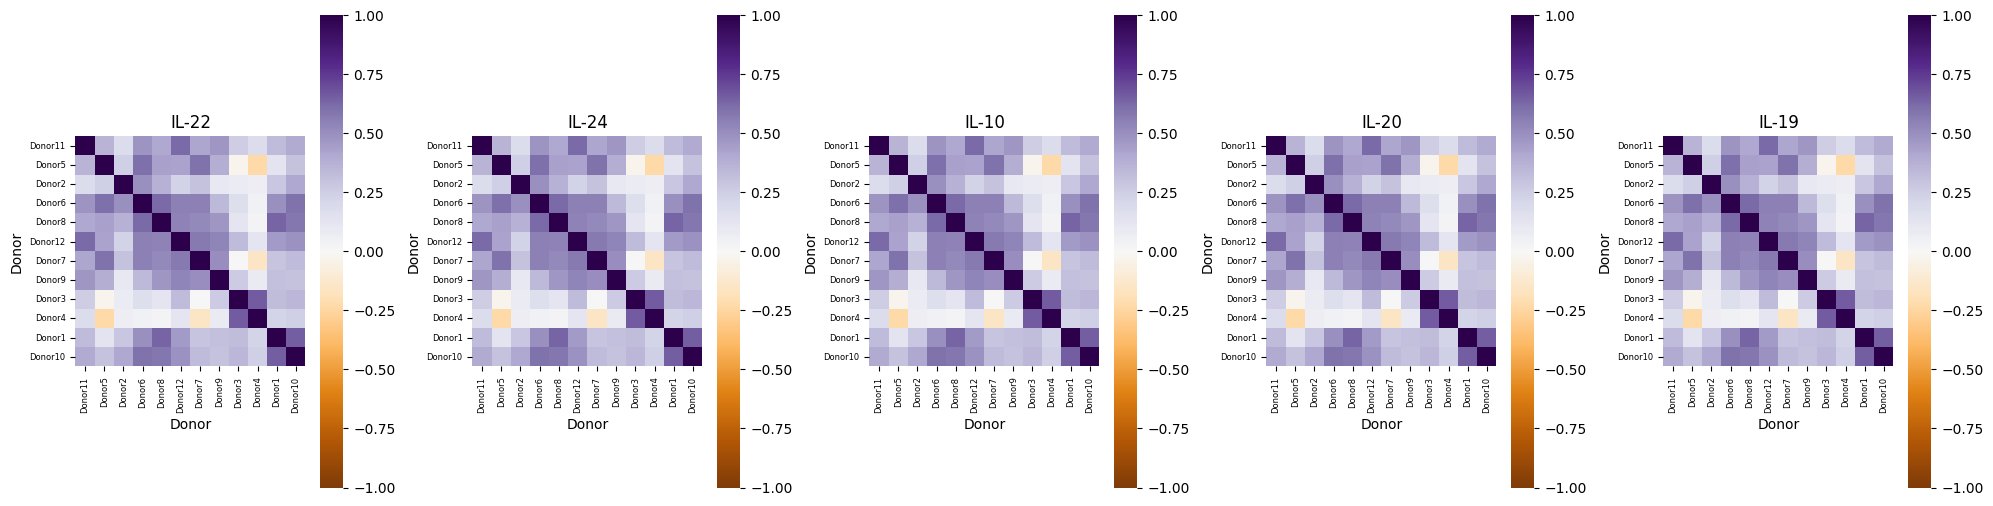

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
heatmap_dict=il10_sims

# Create a figure with subplots (3 rows x 4 columns for 12 plots)
fig, axes = plt.subplots(3, 5, figsize=(20, 15))  # Adjust the size as needed
axes = axes.flatten()  # Flatten to easily iterate over

# Iterate through the dictionary and plot each heatmap
for idx, (key, df) in enumerate(heatmap_dict.items()):
    sns.heatmap(
        df,
        cmap="PuOr",
        vmin=-1,
        vmax=1,
        xticklabels=True,
        yticklabels=True,
        square=True,
        ax=axes[idx]  # Use the current subplot
    )
    axes[idx].set_title(key, fontsize=12)
    axes[idx].set_xlabel("Donor", fontsize=10)
    axes[idx].set_ylabel("Donor", fontsize=10)
    axes[idx].tick_params(axis='x', labelsize=6, rotation=90)
    axes[idx].tick_params(axis='y', labelsize=6)

# Remove empty subplots if dictionary has less than 12 entries
for i in range(len(heatmap_dict), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()

#plt.savefig(os.path.join(output_dir, "donor_family_similarity_heatmaps.pdf"), format="pdf", bbox_inches="tight")

# Display the plot
plt.show()
